神经风格迁移中，取一个内容图像和一个风格图像，综合内容图像的内容和风格图像的艺术风格生成新的图像。

## 加载数据

图片来源http://www.erinloree.com/2012

In [27]:
# 加载内容图片和风格图片
from PIL import Image
path2content= "./data/content.jpg"
path2style= "./data/style.jpg"

content_img = Image.open(path2content)
style_img = Image.open(path2style)

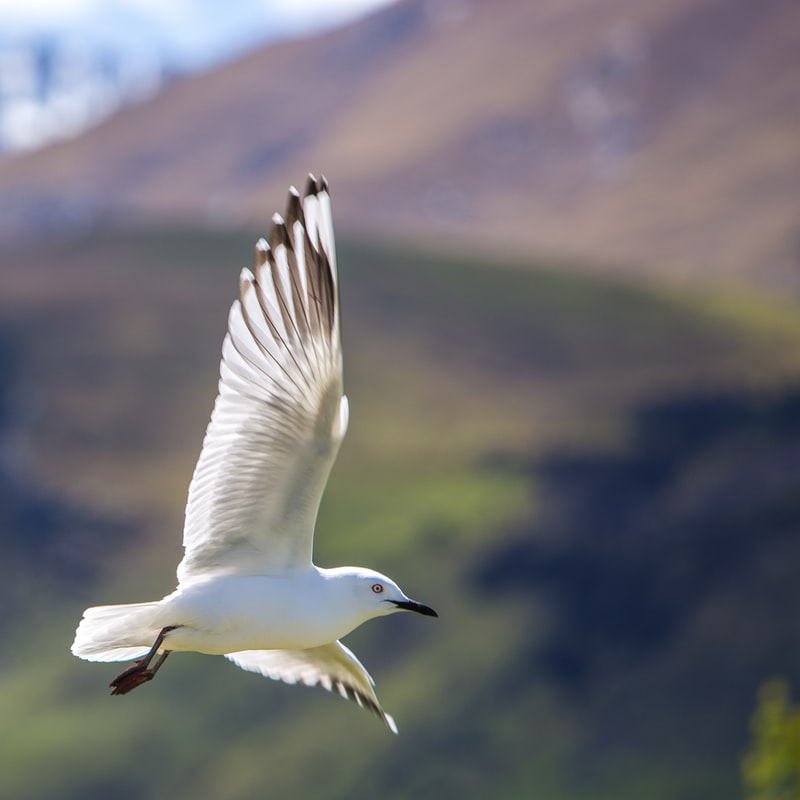

In [28]:
content_img

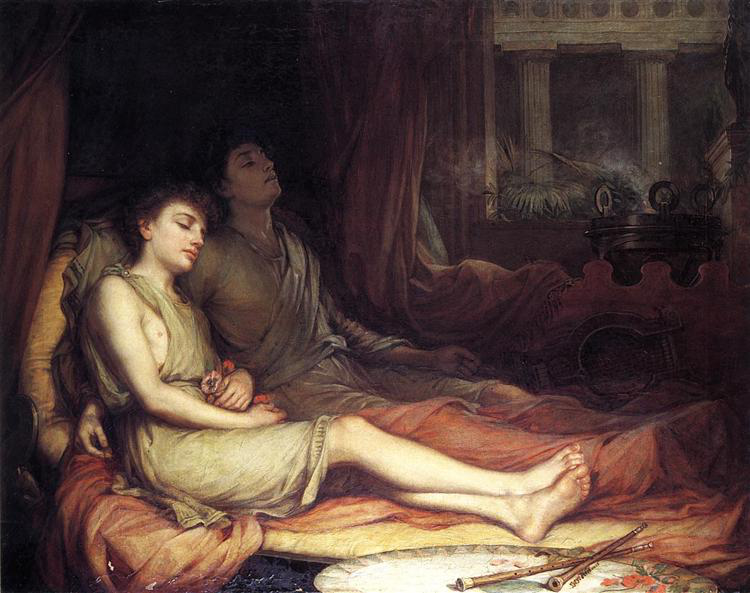

In [29]:
style_img

In [30]:
# 调用torchvision.transforms包中Resize、ToTensor和Normalize对图像进行预处理

import torchvision.transforms as transforms

h, w = 256, 384 
mean_rgb = (0.485, 0.456, 0.406)
std_rgb = (0.229, 0.224, 0.225)

# 定义一个transformer，用于对图像进行预处理
transformer = transforms.Compose([
                    # 将图像缩放到指定大小
                    transforms.Resize((h,w)),  
                    # 将图像转换为张量
                    transforms.ToTensor(),
                    # 对图像进行归一化处理
                    transforms.Normalize(mean_rgb, std_rgb)])  

# 进行预处理
content_tensor = transformer(content_img)
style_tensor = transformer(style_img)

In [33]:
# 克隆content_tensor作为输入图像，并设置requires_grad为True，表示需要计算梯度
input_tensor = content_tensor.clone().requires_grad_(True)
print(input_tensor.shape, input_tensor.requires_grad)

torch.Size([3, 256, 384]) True


In [34]:
import torch
from torchvision.transforms.functional import to_pil_image
# 将图像张量转换为所需PIL图像
def imgtensor2pil(img_tensor):
    # 克隆并分离图像张量
    img_tensor_c = img_tensor.clone().detach()
    # 将图像张量乘以标准RGB值
    img_tensor_c*=torch.tensor(std_rgb).view(3,1,1)
    # 将图像张量加上均值RGB值
    img_tensor_c+=torch.tensor(mean_rgb).view(3,1,1)
    # 将图像张量限制在0到1之间
    img_tensor_c = img_tensor_c.clamp(0,1)
    # 将图像张量转换为PIL图像
    img_pil=to_pil_image(img_tensor_c)
    # 返回PIL图像
    return img_pil

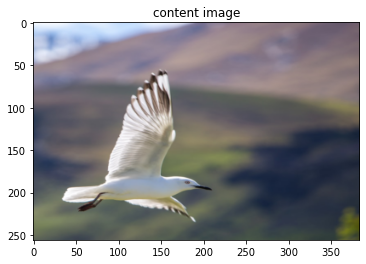

In [35]:
# 展示处理后的图像
import matplotlib.pylab as plt
%matplotlib inline

plt.imshow(imgtensor2pil(content_tensor))
plt.title("content image");

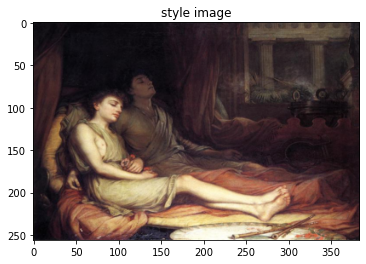

In [36]:
plt.imshow(imgtensor2pil(style_tensor))
plt.title("style image");

# 神经风格迁移模型

常规深度学习步骤：加载输入和目标数据，定义模型、损失函数和优化器，使用SGD/Adam算法更新模型参数来训练模型。
在常规步骤中，模型的输入在训练过程中保持不变，模型参数被更新。

神经风格转移：保持模型参数不变，更新模型的输入。

## 加载预训练的VGG19模型

https://arxiv.org/pdf/1409.1556

VGG19，包含16个卷积层和3个全连接层

![alt text](Snipaste_2024-08-21_15-08-04.png)

In [37]:
import torchvision.models as models
# 检查是否有可用的GPU，如果没有则使用CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 加载预训练的VGG19模型，并将其特征提取部分移动到指定的设备上，并将其设置为评估模式
model_vgg = models.vgg19(pretrained=True).features.to(device).eval()
# 将模型的所有参数设置为不需要梯度，即不进行反向传播，冻结模型参数
for param in model_vgg.parameters():
    param.requires_grad_(False)   
print(model_vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 定义损失函数

In [38]:
# 定义函数，获取模型中指定层的特征，用于计算内容和风格损失值
def get_features(x, model, layers):
    # 创建一个空字典，用于存储特征
    features = {}
    # 遍历模型的所有子层
    for name, layer in enumerate(model.children()):
        # 将输入数据传入子层，得到输出数据
        x = layer(x)
        # 如果子层的名称在指定的层列表中
        if str(name) in layers:
            # 将输出数据存储到字典中，键为子层的名称
            features[layers[str(name)]] = x
    # 返回字典
    return features

# 定义函数，用于计算gram矩阵，Gram矩阵将用于计算风格损失值
def gram_matrix(x):
    # 获取输入张量的维度
    n, c, h, w = x.size()
    # 将输入张量展平
    x = x.view(n*c, h * w)
    # 计算gram矩阵
    gram = torch.mm(x, x.t())
    return gram

import torch.nn.functional as F

# 定义函数，获取内容损失
def get_content_loss(pred_features, target_features, layer):
    # 获取目标特征
    target= target_features[layer]
    # 获取预测特征
    pred = pred_features [layer]
    # 计算均方误差损失
    loss = F.mse_loss(pred, target)
    return loss

# 定义函数，获取风格损失
def get_style_loss(pred_features, target_features, style_layers_dict):  
    # 初始化损失为0
    loss = 0
    # 遍历style_layers_dict中的每一层
    for layer in style_layers_dict:
        # 获取预测特征
        pred_fea = pred_features[layer]
        # 计算预测特征的gram矩阵
        pred_gram = gram_matrix(pred_fea)
        # 获取预测特征的shape
        n, c, h, w = pred_fea.shape
        # 获取目标特征的gram矩阵
        target_gram = gram_matrix (target_features[layer])
        # 计算当前层的损失
        layer_loss = style_layers_dict[layer] *  F.mse_loss(pred_gram, target_gram)
        # 将当前层的损失加到总损失中
        loss += layer_loss/ (n* c * h * w)
    # 返回总损失
    return loss

In [42]:
# 定义特征层字典，用于存储不同层的特征
feature_layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  
                  '28': 'conv5_1'}

# 将内容和风格张量增加一个维度，并将其移动到指定设备上
con_tensor = content_tensor.unsqueeze(0).to(device)
sty_tensor = style_tensor.unsqueeze(0).to(device)

# 用前面定义的get_features获取内容和风格张量的特征
content_features = get_features(con_tensor, model_vgg, feature_layers)
style_features = get_features(sty_tensor, model_vgg, feature_layers)

In [43]:
# 示例，打印内容特征的形状
for key in content_features.keys():
    print(content_features[key].shape)

torch.Size([1, 64, 256, 384])
torch.Size([1, 128, 128, 192])
torch.Size([1, 256, 64, 96])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 32, 48])
torch.Size([1, 512, 16, 24])


## 定义优化器

In [44]:
from torch import optim

# 克隆内容张量作为输入张量，并设置requires_grad_为True，表示需要计算梯度
input_tensor = con_tensor.clone().requires_grad_(True)
# 使用Adam优化器，优化input_tensor，学习率为0.01
optimizer = optim.Adam([input_tensor], lr=0.01)

## 运行模型

In [45]:
# 定义训练的轮数
num_epochs = 300
# 定义内容损失的权重
content_weight = 1e1
# 定义风格损失的权重
style_weight = 1e4
# 定义内容层
content_layer = "conv5_1"
# 定义风格层及其权重
style_layers_dict = { 'conv1_1': 0.75,
                      'conv2_1': 0.5,
                      'conv3_1': 0.25,
                      'conv4_1': 0.25,
                      'conv5_1': 0.25}

# 遍历每一轮
for epoch in range(num_epochs+1):
    # 梯度清零
    optimizer.zero_grad()
    # 获取输入特征
    input_features = get_features(input_tensor, model_vgg, feature_layers)
    # 获取内容损失
    content_loss = get_content_loss (input_features, content_features, content_layer)
    # 获取风格损失
    style_loss = get_style_loss(input_features, style_features, style_layers_dict)
    # 计算神经损失
    neural_loss = content_weight * content_loss + style_weight * style_loss
    # 反向传播
    neural_loss.backward(retain_graph=True)
    # 更新参数
    optimizer.step()
    
    # 每隔100轮打印一次损失
    if epoch % 100 == 0:
        print('epoch {}, content loss: {:.2}, style loss {:.2}'.format(
          epoch,content_loss, style_loss))

epoch 0, content loss: 0.0, style loss 3.5e+01
epoch 100, content loss: 3.3, style loss 4.2
epoch 200, content loss: 3.6, style loss 2.3
epoch 300, content loss: 3.7, style loss 1.6


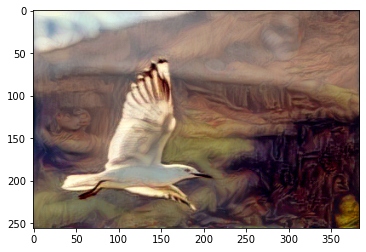

In [46]:
plt.imshow(imgtensor2pil(input_tensor[0].cpu()));

![alt text](image-1.png)